I should write stuff here

## Notes to self
- I removed clm, numclaims. Only focusing on claimcst0. Is there a way to train the model on clm, numclaims such that it somehow improves the accuracy???
- Alot of the claimcst0 have no values and only a few have non-zero value, is there something we can do here???

### Imports & Global Variables

In [1553]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
# place imports back here

In [1554]:
import os, sys
PATH = %pwd
PATH = PATH.split(os.path.sep)
PATH = os.path.sep.join(PATH[:-2]) #removes last 2 directories, gets path to repository

import warnings
warnings.filterwarnings("ignore", "is_sparse")

### Preprocessing

In [1555]:
# (1) Read both train/test + validation & preform equal preprocessing on it
df_t = pd.read_csv(os.path.join(PATH, 'dataset', 'InsNova_data_2023_train.csv'))
df_t['is_val'] = 0
df_v = pd.read_csv(os.path.join(PATH, 'dataset', 'InsNova_data_2023_vh.csv'))
df_v['is_val'] = 1
total_df = pd.concat([df_t,df_v], ignore_index=True)

In [1556]:
# Note
col_categorical = ['veh_body', 'gender', 'area', 'engine_type', 'veh_color', 
                'marital_status', 'time_of_week_driven', 'time_driven']
col_continuous = ['veh_value', 'exposure', 'credit_score']
col_discrete = ['veh_age', 'agecat', 'max_power', 'driving_history_score',
                'e_bill', 'trm_len', 'high_education_ind']

# (2) Feature Manipulation
# (2.1) Continuous/Discrete scaling
from sklearn.preprocessing import RobustScaler
rs = RobustScaler()
total_df[col_continuous] = rs.fit_transform(total_df[col_continuous])
total_df[col_discrete] = rs.fit_transform(total_df[col_discrete])

# (2.2) Categorical processing
total_df = pd.get_dummies(data=total_df,columns=col_categorical, dtype=float)

# Replace whitespace with underscore ' ' -> '_'
total_df.columns = total_df.columns.str.replace(' ', '_')

# (3) separate total_df
df_t = total_df[total_df['is_val'] == 0]
df_t = df_t.drop(columns=['is_val','clm','numclaims']) # !removing clm, numclaims
df_v = total_df[total_df['is_val'] == 1]
df_v = df_v.drop(columns=['is_val', 'clm','numclaims', 'claimcst0']) #realized df_v had this columns when merged with df_t
del total_df

### Issues
- Imbalanced


In [1557]:
claimcst0_percentage = (len(df_t[(df_t['claimcst0'] > 0)])/len(df_t['claimcst0']))*100
print(f"df_t claimcst0 percentage: {claimcst0_percentage}%")

df_t claimcst0 percentage: 6.817277510057916%


In [1558]:
df_t_zero = df_t[df_t['claimcst0'] == 0]
df_t_non_0 = df_t[df_t['claimcst0'] > 0]

print(f"zero_shape: {df_t_zero.shape} | non-zero_shape: {df_t_non_0.shape}")

zero_shape: (21077, 54) | non-zero_shape: (1542, 54)


In [1559]:
'''
#FUNCTION: should reimplement such that we partition non_zero equally by some constant, rn there can be non zero samples in the batch that show up multiple times
def get_train_batch(zero, non_zero):
    collection = list()
    factor = len(zero)//len(non_zero)
    l = non_zero.shape[0]
    for i in range(factor):
        zero_partition = zero[(i*l+1):(i+1)*l]
        df_train = pd.concat([zero_partition, non_zero], axis=0)
        X_train = df_train.drop(['id', 'claimcst0'], axis='columns')
        y_train = df_train['claimcst0']        
        collection.append((X_train,y_train))
    return collection

training_examples = get_train_batch(df_t_zero, df_t_non_0)
'''
factor = len(df_t_zero)//len(df_t_non_0)
df_t_non_0 = factor * df_t_non_0
train_df = pd.concat([df_t_zero,df_t_non_0], axis=0)

### Model Creation

In [1560]:
'''
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


X = train_df.drop(['id','claimcst0'], axis=1)
y = train_df['claimcst0']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

params = {
    "objective": "regression",  # Regression task
    "metric": "mse",  # Mean Squared Error
    "boosting_type": "gbdt",  # Gradient Boosting Decision Tree
    "num_leaves": 50,
    "learning_rate": 0.05,
    "n_estimators": 100,
}

model = lgb.train(params, train_data, num_boost_round=10000, valid_sets=[test_data], verbose_eval=100)
y_pred = model.predict(X_test, num_iteration=model.best_iteration)

mse = mean_squared_error(y_test, y_pred)
print(mse)
'''

'\nimport lightgbm as lgb\nfrom sklearn.model_selection import train_test_split\nfrom sklearn.metrics import mean_squared_error\n\n\nX = train_df.drop([\'id\',\'claimcst0\'], axis=1)\ny = train_df[\'claimcst0\']\n\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)\n\ntrain_data = lgb.Dataset(X_train, label=y_train)\ntest_data = lgb.Dataset(X_test, label=y_test, reference=train_data)\n\nparams = {\n    "objective": "regression",  # Regression task\n    "metric": "mse",  # Mean Squared Error\n    "boosting_type": "gbdt",  # Gradient Boosting Decision Tree\n    "num_leaves": 50,\n    "learning_rate": 0.05,\n    "n_estimators": 100,\n}\n\nmodel = lgb.train(params, train_data, num_boost_round=10000, valid_sets=[test_data], verbose_eval=100)\ny_pred = model.predict(X_test, num_iteration=model.best_iteration)\n\nmse = mean_squared_error(y_test, y_pred)\nprint(mse)\n'

In [1561]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import train_test_split

X = train_df.drop(['id','claimcst0'], axis=1)
y = train_df['claimcst0']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = torch.FloatTensor(X_train.values)
y_train = torch.FloatTensor(y_train.values).view(-1,1)
X_test = torch.FloatTensor(X_test.values)
y_test = torch.FloatTensor(y_test.values).view(-1,1)

print(X_train.shape)

torch.Size([18095, 52])


In [1562]:
class Model(nn.Module):
    def __init__(self, num_categories, num_layers, num_layer_size):
        super().__init__()

        self.embedding_layer = nn.Linear(num_categories, num_layer_size)
        self.layers = nn.ModuleList([nn.Linear(num_layer_size, num_layer_size) for _ in range(num_layers)])
        self.output_layer = nn.Linear(num_layer_size, 1)

    def forward(self, x):
        x = self.embedding_layer(x)  # Assuming x is a tensor with integer category values
        for layer in self.layers:
            x = F.relu(layer(x))
        x = self.output_layer(x)
        return x

In [1563]:
NUM_EPOCHS = 1000
NUM_INPUT_FEATURE = X_train.shape[1]
NUM_LAYERS = 4
NUM_NODES_PER_LAYER = 32
NUM_NO_VAL_LOSS_IMPROVE = 30

model = Model(NUM_INPUT_FEATURE,
              NUM_LAYERS,
              NUM_NODES_PER_LAYER)
criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=0.01)

In [1564]:
val_no_improve_counter = 0
best_val_loss = float('inf')

train_losses = []
val_losses = []
for epoch in range(NUM_EPOCHS):
    outputs = model(X_train)
    loss = criterion(outputs, y_train)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{NUM_EPOCHS}], Loss: {loss.item():.4f}')
        
    #Val
    with torch.no_grad():
        val_outputs = model(X_test)
        val_loss = criterion(val_outputs, y_test)
        print(f'Validation Loss: {val_loss.item():.4f}')

        # Check if the validation loss has increased
        if val_loss > best_val_loss:
            val_no_improve_counter += 1
            if val_no_improve_counter >= NUM_NO_VAL_LOSS_IMPROVE:
                print(f'Early stopping at epoch {epoch+1}. Validation loss stopped improving.')
                break  # Stop training
        else:
            best_val_loss = val_loss
            counter = 0
    
    train_losses.append(loss.item())
    val_losses.append(val_loss.item())

Validation Loss: 2196.3120
Validation Loss: 2196.3113
Validation Loss: 2196.3201
Validation Loss: 2196.3142
Validation Loss: 2196.3020
Validation Loss: 2196.2854
Validation Loss: 2196.2908
Validation Loss: 2196.2908
Validation Loss: 2196.2800
Epoch [10/1000], Loss: 2100.4512
Validation Loss: 2196.2651
Validation Loss: 2196.2632
Validation Loss: 2196.2493
Validation Loss: 2196.2253
Validation Loss: 2196.1926
Validation Loss: 2196.1497
Validation Loss: 2196.0864
Validation Loss: 2195.9973
Validation Loss: 2195.8691
Validation Loss: 2195.6741
Epoch [20/1000], Loss: 2099.7766
Validation Loss: 2195.3721
Validation Loss: 2194.9150
Validation Loss: 2194.2639
Validation Loss: 2193.2500
Validation Loss: 2191.7678
Validation Loss: 2189.5894
Validation Loss: 2186.3223
Validation Loss: 2181.7681
Validation Loss: 2174.9436
Validation Loss: 2165.2839
Epoch [30/1000], Loss: 2062.8408
Validation Loss: 2152.8464
Validation Loss: 2137.8433
Validation Loss: 2120.8557
Validation Loss: 2102.9045
Validation

In [1565]:
with torch.no_grad():
    val_outputs = model(X_test)
    val_loss = criterion(val_outputs, y_test)
    
    # Convert PyTorch tensors back to NumPy arrays for easier printing
    val_outputs_np = val_outputs.numpy()
    y_test_np = y_test.numpy()
    
    # Print predictions and true values side by side
    for i in range(len(y_test)):
        print(f"Prediction: {val_outputs_np[i][0]:.4f}, True Value: {y_test_np[i][0]:.4f}")

    print(f'Validation Loss: {val_loss.item():.4f}')


Prediction: 0.0326, True Value: 0.0000
Prediction: -0.0025, True Value: 0.0000
Prediction: -0.0564, True Value: 0.0000
Prediction: -0.0067, True Value: 0.0000
Prediction: -0.0644, True Value: 0.0000
Prediction: 0.0699, True Value: 0.0000
Prediction: -0.0945, True Value: 0.0000
Prediction: -0.0477, True Value: 0.0000
Prediction: 0.0699, True Value: 0.0000
Prediction: 0.0031, True Value: 0.0000
Prediction: -0.0241, True Value: 0.0000
Prediction: -0.0549, True Value: 0.0000
Prediction: -0.0553, True Value: 0.0000
Prediction: 0.0359, True Value: 0.0000
Prediction: 0.0478, True Value: 0.0000
Prediction: -0.0827, True Value: 0.0000
Prediction: -0.0290, True Value: 0.0000
Prediction: -0.0448, True Value: 0.0000
Prediction: -0.1072, True Value: 0.0000
Prediction: 0.0241, True Value: 0.0000
Prediction: -0.0071, True Value: 0.0000
Prediction: -0.0401, True Value: 0.0000
Prediction: -0.1084, True Value: 0.0000
Prediction: -0.0772, True Value: 0.0000
Prediction: -0.0431, True Value: 0.0000
Predict

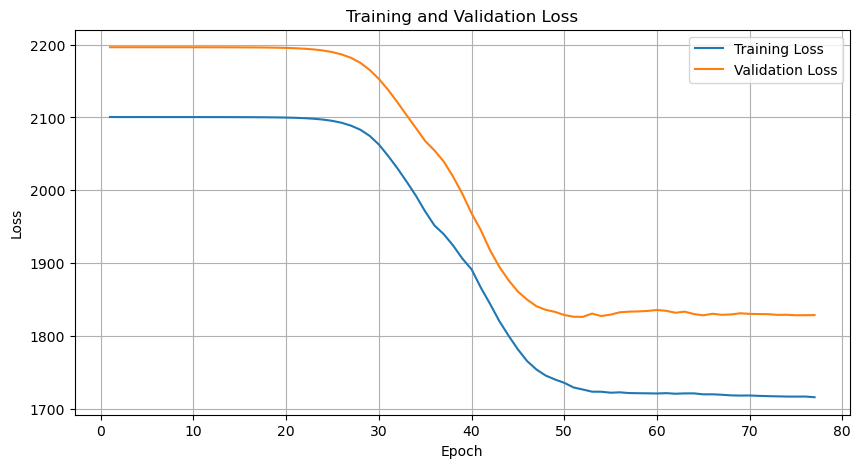

In [1566]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.grid(True)
plt.show()

In [1567]:
df_v = df_v.drop('id', axis=1)
val_dataset = torch.FloatTensor(df_v.values)
val_outputs = model(val_dataset)

val_outputs = torch.where((val_outputs <= 10) & (val_outputs >= -10), torch.tensor(0.0), val_outputs)
val_outputs = pd.DataFrame(val_outputs.detach().numpy(), columns=['Predict'])
val_outputs.rename_axis('id', inplace=True)
val_outputs.index += 1
val_outputs.to_csv('NN_Submission.csv', index=True)